In [1]:
import sys
import os

import numpy as np
import pandas as pd
from subprocess import call
from sklearn.metrics import mean_squared_error

from numpy.linalg import solve

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Train Data

In [2]:
PROJECT_PATH = '/home/5124393/ML_Tips/08_Recommend/'
DATA_FILE_PATH = os.path.join(PROJECT_PATH, 'data')

In [153]:
df_time_context = pd.DataFrame()
for category_id in range(4):
    df = pd.read_csv(os.path.join(DATA_FILE_PATH, 'train',
                                    'category_id_{}_recommend_table_week_201904.csv'.format(str(category_id))))
    df = df[['cuid', 'genre_id', 'time', 'poi_type', 'score']]
    df_time_context = pd.concat([df_time_context, df])

In [14]:
df_time_context.head()

,cuid,genre_id,time,poi_type,score
0,04GG05555QJN55QTP4O05TPL,0,0,13,77
1,04GG05555QJN55QTP4O05TPL,0,1,13,32
2,04GG05555QJN55QTP4O05TPL,0,2,13,20
3,04GG05555QJN55QTP4O05TPL,0,3,13,17
4,04GG05555QJN55QTP4O05TPL,0,4,13,18


In [15]:
print(len(df_time_context['cuid'].unique()))
print(len(df_time_context['genre_id'].unique()))
print(len(df_time_context['time'].unique()))
print(len(df_time_context['poi_type'].unique()))

7082
4
24
24


In [26]:
df_time_context['genre_id'].value_counts()

0    39731
1    17444
2    10739
3    10504
Name: genre_id, dtype: int64

In [25]:
df_time_context['time'].value_counts()

18    4969
19    4886
17    4712
20    4582
21    4569
12    4153
22    4142
16    4080
13    3907
15    3906
14    3615
11    3590
23    3457
10    3329
8     3312
9     3251
7     2911
0     2681
6     2051
1     1895
2     1257
5     1249
3     1029
4      885
Name: time, dtype: int64

In [24]:
df_time_context['poi_type'].value_counts()

13     34968
110     7414
134     7324
61      5844
14      5333
37      5256
38      4080
109     3852
62      1250
85      1159
86      1008
133      392
104      128
32       103
98        95
26        48
157       43
80        43
158       33
74        21
2         15
56         7
8          1
50         1
Name: poi_type, dtype: int64

In [37]:
cuid_num_for_genre =  df_time_context.groupby('genre_id')['cuid'].unique()
for genre in range(len(cuid_num_for_genre)):
    print('genre_id: {}, cuid num: {}'.format(genre, len(cuid_num_for_genre[genre])))

genre_id: 0, cuid num: 4781
genre_id: 1, cuid num: 2512
genre_id: 2, cuid num: 1729
genre_id: 3, cuid num: 1565


# score matrix

## index

In [56]:
import scipy.sparse as sparse
import itertools

def to_event_index(genre, time, context):
    return df_genre_time_context[(df_genre_time_context['time'] == time)
                               & (df_genre_time_context['genre_index'] == genre)
                               & (df_genre_time_context['context_index'] == context)].index[0]

def get_index_list(df):
    
    #indexing
    unique_cuids = set(df.cuid.unique())
    u2i = {u:i for i, u in enumerate(unique_cuids)}
    i2u = {i:u for i, u in enumerate(unique_cuids)}
    
    unique_genres = set(df.genre_id.unique())
    g2i = {g:i for i, g in enumerate(unique_genres)}
    i2g = {i:g for i, g in enumerate(unique_genres)}
    
    unique_contexts = set(df.poi_type.unique())
    c2i = {c:i for i, c in enumerate(unique_contexts)}
    i2c = {i:c for i, c in enumerate(unique_contexts)}
    
    df['cuid_index'] = df['cuid'].map(lambda x:u2i[x])
    df['genre_index'] = df['genre_id'].map(lambda x:g2i[x])
    df['context_index'] = df['poi_type'].map(lambda x:c2i[x])
    
    num_cuid = len(unique_cuids)
    num_genre = len(unique_genres)
    num_context = len(unique_contexts)
    num_time = 24
    
#     print('To sparse matrix')
    # To sparse matrix
    lst = list(itertools.product(range(num_genre), range(num_time), range(num_context)))
    global df_genre_time_context
    df_genre_time_context = pd.DataFrame(lst, columns=['genre_index', 'time', 'context_index'])
    df_genre_time_context.reset_index(inplace=True)
    df_genre_time_context = df_genre_time_context.rename(columns={'index': 'event_index'})
    
    #df['event_index'] = df.apply(lambda x: to_event_index(x['genre_index'], x['time'], x['context_index']), axis=1)
#     cols = ['cuid', 'genre_id', 'time', 'poi_type', 'context', 'context_genre_num', 'context_num', 'score', 'cuid_index', 'genre_index', 'context_index']
    cols = ['cuid', 'genre_id', 'time', 'poi_type', 'score', 'cuid_index', 'genre_index', 'context_index']
    df = pd.merge(df[cols], df_genre_time_context, on=['genre_index', 'time', 'context_index'])
    
    uids = np.array(df['cuid_index'])
    eids = np.array(df['event_index'])
    probs = np.array(df['score'])
    
#     count_sparse = sparse.csr_matrix((probs, (uids, eids)), shape=(uids.max()+1, eids.max()+1))
    
    return uids, eids, probs
#     return count_sparse, uids, eids, probs

In [156]:
uids, eids, probs = get_index_list(df_time_context)

In [83]:
uids

array([4956, 5412,  205, ..., 6760, 5084, 6461])

In [84]:
eids

array([   4,    4,    4, ..., 2233, 1877, 1819])

In [85]:
probs

array([77,  8, 16, ...,  7,  4,  9])

## array

In [157]:
probs_array = np.zeros((uids.max()+1, eids.max()+1))
for prob in range(len(probs)):
    probs_array[uids[prob], eids[prob]] = probs[prob]

In [158]:
probs_array.shape

(7082, 2304)

In [91]:
# sparsity
matrix_size = np.prod(probs_array.shape)
interaction = np.flatnonzero(probs_array).shape[0] # retrun "indices" tha are non-zero
sparsity = (interaction/matrix_size)

In [92]:
sparsity

0.0048059291552919768

In [93]:
probs_array

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,  36., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [76]:
interaction

7082

In [75]:
matrix_size

16316928

## sparse matrix

In [62]:
probs_sm = sparse.csr_matrix((probs, (uids, eids)), shape=(uids.max()+1, eids.max()+1))

In [63]:
probs_sm

<7082x2304 sparse matrix of type '<class 'numpy.int64'>'
	with 78418 stored elements in Compressed Sparse Row format>

In [45]:
24*24*4

2304

In [46]:
78418/(7082*2304)

0.004805929155291977

In [68]:
(7082*2304)

16316928

In [94]:
probs_sm.indices

array([ 604,  748,  791, ..., 1454, 1876, 2030], dtype=int32)

In [95]:
probs_sm.data

array([ 8,  7,  3, ..., 10,  9, 10], dtype=int64)

In [98]:
probs_sm.indptr

array([    0,    44,    54, ..., 78388, 78407, 78418], dtype=int32)

In [99]:
probs_array[0][604]

8.0

In [101]:
probs_array[0][748]

7.0

# MSE

In [102]:
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

## plot MSE

In [103]:
def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

# MF with ALS, SGD

for general array (**not** for sparse matrix)

In [106]:
class MF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
#     def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
    def calculate_learning_curve(self, iter_array, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
#         self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
#             self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
#                 print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [159]:
train = probs_array

## ALS

In [107]:
MF_ALS = MF(train, 40, learning='als', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
iter_array = [1, 2, 5, 10, 25]
MF_ALS.calculate_learning_curve(iter_array, learning_rate=0.001)

Iteration: 1
Train mse: 187.191923301
Iteration: 2
Train mse: 142.955972178
Iteration: 5
Train mse: 137.96692538
Iteration: 10
Train mse: 137.900219038
Iteration: 25
	current iteration: 10
Train mse: 138.030620883


In [110]:
predict_array = MF_ALS.predict_all()

In [111]:
predict_array

array([[ -1.92852635e-03,  -4.55330138e-03,   9.68754334e-02, ...,
          4.78859682e-04,  -2.37145419e-02,  -8.87913825e-02],
       [ -1.97008449e-03,  -1.69364819e-02,   3.40274780e-02, ...,
          1.07037450e-03,   7.16645823e-02,   2.51959841e-02],
       [  4.04531118e-03,   6.88860854e-04,  -1.26489927e-03, ...,
          9.24530496e-04,  -1.27161011e-01,  -1.28569279e-01],
       ..., 
       [ -5.57931915e-04,   4.56279498e-04,   3.58317306e-01, ...,
          1.05376587e-03,  -1.38336944e-01,  -1.27938822e-01],
       [  7.95458370e-04,   1.18521801e-01,   8.59483062e+00, ...,
          4.97403636e-04,   4.09955005e-03,   1.40624090e-02],
       [  8.39392356e-04,  -9.34038693e-03,   1.12843605e-01, ...,
          7.13358636e-04,  -3.54881741e-02,  -5.17645109e-02]])

## SGD

In [160]:
MF_SGD = MF(train, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, learning_rate=0.001)

Iteration: 1
Train mse: 149.374690204
Iteration: 2
Train mse: 145.820511172
Iteration: 5
Train mse: 123.616219475
Iteration: 10
Train mse: 104.690802293
Iteration: 25
	current iteration: 10
Train mse: 38.5033325461


In [161]:
predict_array = MF_SGD.predict_all()

In [162]:
predict_array

array([[ 13.11265669,  12.97208305,  12.2663652 , ...,  12.67757015,
         12.71025652,  12.48835175],
       [ 14.21211266,  13.92641258,   9.85914187, ...,  13.75752157,
         13.18130312,  13.27124582],
       [ 14.34344707,  14.19617854,  13.02431317, ...,  13.99210664,
         13.58583161,  13.79653552],
       ..., 
       [ 16.00480902,  15.53100093,  12.34990427, ...,  15.56948474,
         15.30219852,  15.46815716],
       [ 15.92600745,  16.10393648,  20.96987519, ...,  15.63971244,
         15.17562895,  15.84884075],
       [ 13.89089311,  13.61868295,  11.80187845, ...,  13.46530034,
         12.99473502,  13.21466696]])

# Make Recommend Table

In [120]:
def make_recommend_table(array, df_orig):
    
    #indexing
    unique_cuids = set(df_orig.cuid.unique())
    u2i = {u:i for i, u in enumerate(unique_cuids)}
    i2u = {i:u for i, u in enumerate(unique_cuids)}
    
    unique_genres = set(df_orig.genre_id.unique())
    g2i = {g:i for i, g in enumerate(unique_genres)}
    i2g = {i:g for i, g in enumerate(unique_genres)}
    
    unique_contexts = set(df_orig.poi_type.unique())
    c2i = {c:i for i, c in enumerate(unique_contexts)}
    i2c = {i:c for i, c in enumerate(unique_contexts)}
    
    mf_recommend_table = pd.DataFrame()
    user_num = array.shape[0]
    
    genre_index_list = df_genre_time_context['genre_index'].values.tolist() * user_num
    time_list = df_genre_time_context['time'].values.tolist() * user_num
    context_index_list = df_genre_time_context['context_index'].values.tolist() * user_num
    
    mf_recommend_table['genre_id'] = genre_index_list
    mf_recommend_table['time'] = time_list
    mf_recommend_table['poi_type'] = context_index_list
    mf_recommend_table['score'] = array.flatten()
    
    cuid_list = []
    all_cuid_list = [cuid_list.extend([i2u[uid] for i in range(len(df_genre_time_context))]) for uid in range(user_num)]
    
    mf_recommend_table['cuid'] = cuid_list
    
    mf_recommend_table['genre_id'] = mf_recommend_table['genre_id'].map(lambda x:i2g[x])
    mf_recommend_table['poi_type'] = mf_recommend_table['poi_type'].map(lambda x:i2c[x])
    
    return mf_recommend_table

In [163]:
df_recommend_table = make_recommend_table(predict_array, df_time_context)

ALS

In [122]:
df_recommend_table.head()

,genre_id,time,poi_type,score,cuid
0,0,0,2,-0.001929,Q5O55L5J55Q0G4NTP4O055P0
1,0,0,133,-0.004553,Q5O55L5J55Q0G4NTP4O055P0
2,0,0,134,0.096875,Q5O55L5J55Q0G4NTP4O055P0
3,0,0,8,0.000000,Q5O55L5J55Q0G4NTP4O055P0
4,0,0,13,-0.041411,Q5O55L5J55Q0G4NTP4O055P0


SGD

In [164]:
df_recommend_table.head()

,genre_id,time,poi_type,score,cuid
0,0,0,2,13.112657,Q5O55L5J55Q0G4NTP4O055P0
1,0,0,133,12.972083,Q5O55L5J55Q0G4NTP4O055P0
2,0,0,134,12.266365,Q5O55L5J55Q0G4NTP4O055P0
3,0,0,8,12.782001,Q5O55L5J55Q0G4NTP4O055P0
4,0,0,13,3.661123,Q5O55L5J55Q0G4NTP4O055P0


base

In [125]:
df_time_context[(df_time_context['cuid']=='04GG05555QJN55QTP4O05TPL') & \
                   (df_time_context['time']==0) & \
                   (df_time_context['poi_type']==13)
                  ]

,cuid,genre_id,time,poi_type,score
0,04GG05555QJN55QTP4O05TPL,0,0,13,77


ALS

In [124]:
df_recommend_table[(df_recommend_table['cuid']=='04GG05555QJN55QTP4O05TPL') & \
                   (df_recommend_table['time']==0) & \
                   (df_recommend_table['poi_type']==13)
                  ]

,genre_id,time,poi_type,score,cuid
11418628,0,0,13,69.261558,04GG05555QJN55QTP4O05TPL
11419204,1,0,13,0.108633,04GG05555QJN55QTP4O05TPL
11419780,2,0,13,-0.700120,04GG05555QJN55QTP4O05TPL
11420356,3,0,13,0.069135,04GG05555QJN55QTP4O05TPL


SGD

In [165]:
df_recommend_table[(df_recommend_table['cuid']=='04GG05555QJN55QTP4O05TPL') & \
                   (df_recommend_table['time']==0) & \
                   (df_recommend_table['poi_type']==13)
                  ]

,genre_id,time,poi_type,score,cuid
11418628,0,0,13,68.616095,04GG05555QJN55QTP4O05TPL
11419204,1,0,13,17.401813,04GG05555QJN55QTP4O05TPL
11419780,2,0,13,-8.804436,04GG05555QJN55QTP4O05TPL
11420356,3,0,13,-7.941026,04GG05555QJN55QTP4O05TPL


# validation

In [134]:
sys.path.append(PROJECT_PATH)

In [135]:
sys.path

['',
 '/home/5124393/anaconda3/lib/python36.zip',
 '/home/5124393/anaconda3/lib/python3.6',
 '/home/5124393/anaconda3/lib/python3.6/lib-dynload',
 '/home/5124393/anaconda3/lib/python3.6/site-packages',
 '/home/5124393/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/home/5124393/.ipython',
 '/home/5124393/ML_Tips/08_Recommend/']

In [136]:
import score

## test table

In [147]:
def get_test_table(category_id, recommend_table):
        # raw use log
        global target_cuid_num
#         target_cuid_num = len(df_use['cuid'].unique())
        target_cuid_num = len(df_time_context[df_time_context['genre_id']==category_id]['cuid'].unique())
        
        ##############################################
        # テストテーブルの取得
        ##############################################
        global test_table
        FILE_NAME = 'category_id_' + str(category_id) + '_test_table_201904.csv'
        test_table = pd.read_csv(os.path.join(DATA_FILE_PATH, 'test', FILE_NAME))
        
        ##############################################
        # テスト期間の状況発生履歴テーブルの取得
        ##############################################
        global test_context_count_table
        FILE_NAME = 'category_id_' + str(category_id) + '_test_context_count_table_201904.csv'
        test_context_count_table = pd.read_csv(os.path.join(DATA_FILE_PATH, 'test', FILE_NAME))
        
        global target_recommend_table
        target_recommend_table = recommend_table[recommend_table['genre_id']==category_id]

## metrics

In [144]:
def metrics_result(recommend_table, test_table, test_context_count_table, train_week_num=4, make_cond='week', is_boolean=False,  category_id=None, target_cuid_num=None, is_dservice=True):
    result_list = []
    for s_th in range(0, 30, 5):
        for k in range(1, 6):
            try:
                delivery_user, actual_delivery_user_num, auc, fpr, tpr, thresholds, true_list, scores_list, precision_list, recall_list, pr_thresholds, ave_precision, precision, recall = \
                score.model_score(recommend_table, s_th, test_table, test_context_count_table, topk=k, is_boolean=is_boolean)
                result_list.append([s_th, k, target_cuid_num, delivery_user, actual_delivery_user_num, auc, precision, recall])
            except:
                result_list.append([s_th, k, target_cuid_num, 0, 0, None, None, 0])
            
    df_result = pd.DataFrame(result_list, columns=['score_threshod', 'topk', 'user_num', 'delivery_user_num', 'actual_delivery_user_num', 'AUC', 'precision', 'recall'])
    return df_result
    
#     FILE_NAME_PREFIX = 'train_week_num_' + str(train_week_num) + '-make_cond_' + str(make_cond) + '-'
#     if is_boolean:
#         if is_dservice:
#             file_name = FILE_NAME_PREFIX + 'boolean-store_id_' + str(store_id) + '.csv'
#         else:
#             file_name = FILE_NAME_PREFIX + 'boolean-category_id_' + str(category_id) + '.csv'
#     else:
#         if is_dservice:
#             file_name = FILE_NAME_PREFIX + 'standard-store_id_' + str(store_id) + '.csv'
#         else:
#             file_name = FILE_NAME_PREFIX + 'standard-category_id_' + str(category_id) + '.csv'
            
#     df_result.to_csv(os.path.join(RESULT_DATA_PATH, file_name))
#     print(file_name + ' is saved!!')

In [166]:
get_test_table(category_id=3, df_recommend_table)
# get_test_table(category_id, df_time_context)
##############################################
# 効果測定
##############################################
# parameter list
df_result = metrics_result(target_recommend_table,
                   test_table, 
                   test_context_count_table, 
                   is_boolean=False, 
                   category_id=category_id, 
                   target_cuid_num=target_cuid_num, 
                   is_dservice=False)

base

In [149]:
df_result

,score_threshod,topk,user_num,delivery_user_num,actual_delivery_user_num,AUC,precision,recall
0,0,1,1565,1565,1343,0.864588,0.072547,0.034649
1,0,2,1565,1565,1450,0.833920,0.064239,0.065978
2,0,3,1565,1565,1474,0.824066,0.063151,0.088833
3,0,4,1565,1565,1478,0.816488,0.060384,0.108855
4,0,5,1565,1565,1480,0.805767,0.058766,0.124845
5,5,1,1565,1406,1195,0.855658,0.080317,0.030164
6,5,2,1565,1406,1294,0.828231,0.070189,0.055463
7,5,3,1565,1406,1314,0.813796,0.069041,0.075848
8,5,4,1565,1406,1318,0.804834,0.066160,0.092609
9,5,5,1565,1406,1319,0.793177,0.064105,0.104770


MF with ALS

In [146]:
df_result

,score_threshod,topk,user_num,delivery_user_num,actual_delivery_user_num,AUC,precision,recall
0,0,1,1565,7082,1521,0.862933,0.054815,0.034094
1,0,2,1565,7082,1596,0.853371,0.053593,0.069403
2,0,3,1565,7082,1635,0.850583,0.049137,0.095192
3,0,4,1565,7082,1651,0.849050,0.047117,0.124532
4,0,5,1565,7082,1660,0.844466,0.044873,0.150349
5,5,1,1565,590,484,0.757773,0.143762,0.021942
6,5,2,1565,590,495,0.762455,0.142857,0.039037
7,5,3,1565,590,502,0.750496,0.128635,0.051259
8,5,4,1565,590,502,0.741827,0.124982,0.062865
9,5,5,1565,590,504,0.728386,0.118022,0.071026


MF with SGD

In [168]:
df_result

,score_threshod,topk,user_num,delivery_user_num,actual_delivery_user_num,AUC,precision,recall
0,0,1,1565,7082,745,0.845834,0.082733,0.015377
1,0,2,1565,7082,1018,0.844690,0.062516,0.025942
2,0,3,1565,7082,1169,0.851784,0.054384,0.035034
3,0,4,1565,7082,1296,0.859702,0.048098,0.041289
4,0,5,1565,7082,1364,0.854132,0.045976,0.048020
5,5,1,1565,7082,745,0.845834,0.082733,0.015377
6,5,2,1565,7082,1018,0.844690,0.062516,0.025942
7,5,3,1565,7082,1169,0.851784,0.054384,0.035034
8,5,4,1565,7082,1296,0.859702,0.048098,0.041289
9,5,5,1565,7082,1364,0.854132,0.045976,0.048020


# distribution

In [150]:
def plot_score_hist(recommend_table):
    recommend_table_score_list = list(recommend_table['score'].values)
    plt.figure(figsize=(12, 10))
    plt.hist(recommend_table_score_list, bins=50)
    plt.tick_params(labelsize=18)

base

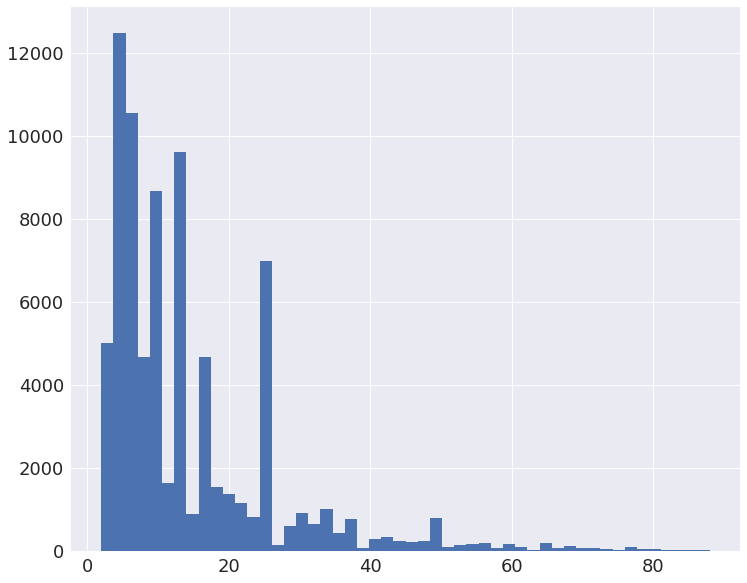

In [151]:
plot_score_hist(df_time_context)

MF with ALS

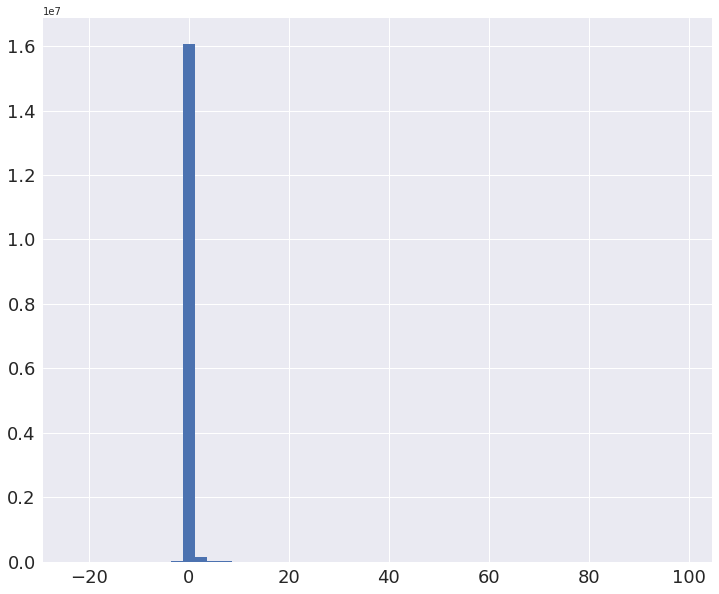

In [152]:
plot_score_hist(df_recommend_table)

MF with SGD

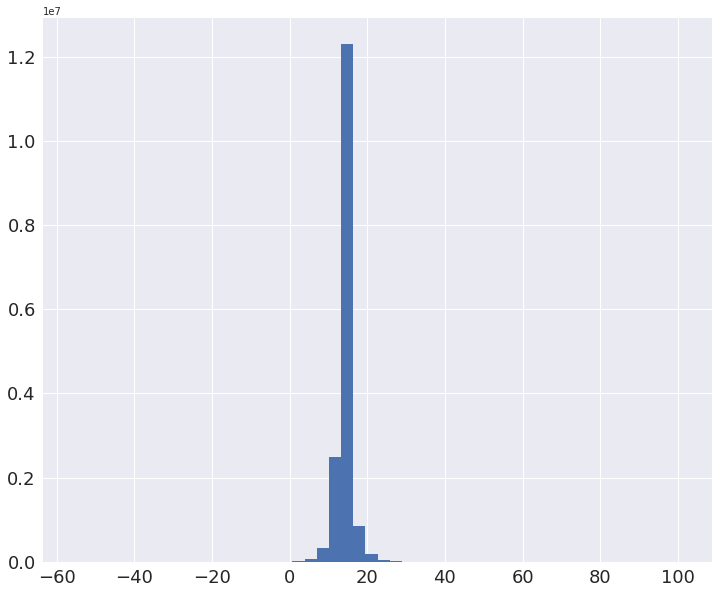

In [169]:
plot_score_hist(df_recommend_table)